In [1]:
from concurrent.futures import (
    ThreadPoolExecutor,
    as_completed,
)
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import os

In [2]:
BASE_DIR = os.path.dirname(os.path.abspath(""))
DATASET_NAME = "Agriculture-Vision-2021/_mini_dataset"
BASE_DIR, DATASET_NAME

('/mnt/d/AgriNet-Research/agrinet/datasets',
 'Agriculture-Vision-2021/_mini_dataset')

In [3]:
dataset_path = os.path.join(BASE_DIR, DATASET_NAME)
dataset_train_path = os.path.join(dataset_path, "train")
dataset_val_path = os.path.join(dataset_path, "val")
dataset_test_path = os.path.join(dataset_path, "test")
dataset_train_path

'/mnt/d/AgriNet-Research/agrinet/datasets/Agriculture-Vision-2021/_mini_dataset/train'

In [4]:
LABELS = {
    0: "drydown",
    1: "nutrient_deficiency",
    2: "weed_cluster",
    3: "water",
    4: "endrow",
    5: "double_plant",
    6: "waterway",
    7: "storm_damage",
    8: "planter_skip",
}

# Check label masks for white pixels

In [5]:
def check_pixels(image_array: np.ndarray, check_for_pixels: int) -> bool:
    return np.any(image_array == check_for_pixels)

def is_label_mask(filepath: str, *, check_for_pixels: int = 255) -> bool:
    try:
        img = Image.open(filepath).convert("L")
        return check_pixels(image_array=np.array(img), check_for_pixels=check_for_pixels)
    except FileNotFoundError:
        # Return False if the file doesnt exist
        return False


def process_label_mask(
    filename: str,
    labels_path: str,
    *,
    ext: str = ".png"
) -> list[int]:
    return [
        1 if is_label_mask(os.path.join(labels_path, label_name, f"{filename}{ext}")) else 0
        for label_name in LABELS.values()
    ]


def process_label_masks_concurrent(
    target_images_paths: list[str],
    labels_path: str,
    *,
    ext: str = ".png",
    max_workers: int = None
) -> pd.DataFrame:
    max_workers = max_workers or cpu_get_max_workers()
    data = []
    columns = ["ID"] + list(LABELS.values())

    def process_single(filepath: str):
        filename, _ = os.path.splitext(os.path.basename(filepath))
        label_results = process_label_mask(
            filename=filename,
            labels_path=labels_path,
            ext=ext
        )
        return [filename] + label_results

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_single, fp): fp for fp in target_images_paths}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing masks", unit="file"):
            data.append(future.result())

    return pd.DataFrame(data, columns=columns)


def cpu_get_max_workers() -> int:
    return os.cpu_count() or 1


def get_filepaths(path: str, *, exts: list[str] = []) -> list[str]:
    return [
        os.path.join(path, filename)
        for filename in os.listdir(path)
        if not exts or os.path.splitext(filename)[1] in exts
    ]

In [6]:
def _test():
    path = os.path.join(dataset_train_path, "labels", "endrow")
    mask1 = os.path.join(path, "2I4YH4WR2_1724-5674-2236-6186.png")
    mask2 = os.path.join(path, "1BFUWHD9T_2585-1539-3097-2051.png")
    assert is_label_mask(mask1) == True
    assert is_label_mask(mask2) == False
    %timeit is_label_mask(mask1)
    print("All test passed")


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test")
except Exception as e:
    print(f"Failed load test: {e}")

6.8 ms ± 443 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
All test passed


In [7]:
def _test():
    limit = 10
    exts = [".jpg",]
    path = os.path.join(dataset_train_path, "images", "rgb")
    target_images_paths = get_filepaths(path, exts = exts)[:limit]
    labels_path = os.path.join(dataset_train_path, "labels")
    
    df = process_label_masks_concurrent(
        target_images_paths = target_images_paths,
        labels_path = labels_path,
    )
    print(df.head())


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test")
except Exception as e:
    print(f"Failed load test: {e}")

Processing masks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.09file/s]

                              ID  drydown  nutrient_deficiency  weed_cluster  \
0  11TAQJ6ET_1148-8089-1660-8601        0                    0             0   
1   11TAQJ6ET_1749-948-2261-1460        0                    0             0   
2   11IE4DKTR_6121-684-6633-1196        0                    0             0   
3  11TAQJ6ET_1422-8427-1934-8939        0                    0             0   
4  11TAQJ6ET_1567-8177-2079-8689        0                    0             0   

   water  endrow  double_plant  waterway  storm_damage  planter_skip  
0      0       0             1         0             0             0  
1      0       0             1         0             0             0  
2      0       0             1         0             0             0  
3      0       0             1         0             0             0  
4      0       0             1         0             0             0  


In [8]:
path = os.path.join(dataset_train_path, "images", "rgb")
target_images_paths = get_filepaths(path)
labels_path = os.path.join(dataset_train_path, "labels")

df = process_label_masks_concurrent(
    target_images_paths = target_images_paths,
    labels_path = labels_path,
)

Processing masks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3517/3517 [00:34<00:00, 102.48file/s]


In [9]:
dn = DATASET_NAME.replace('/','').lower()
filename = f"{dn}_processed_masks.csv"
df.to_csv(filename, index=False)

# EDA

In [10]:
df = pd.read_csv("agriculture-vision-2021_mini_dataset_processed_masks.csv")

In [11]:
df.head()

,ID,drydown,nutrient_deficiency,weed_cluster,water,endrow,double_plant,waterway,storm_damage,planter_skip
0,11TAQJ6ET_1148-8089-1660-8601,0,0,0,0,0,1,0,0,0
1,11IE4DKTR_11556-9586-12068-10098,0,0,0,0,0,1,0,0,0
2,11TAQJ6ET_1288-961-1800-1473,0,0,0,0,0,1,0,0,0
3,11TAQJ6ET_1995-8426-2507-8938,0,0,0,0,0,1,0,0,0
4,11TAQJ6ET_2172-7065-2684-7577,0,0,0,0,0,1,0,0,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3517 entries, 0 to 3516
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   3517 non-null   object
 1   drydown              3517 non-null   int64 
 2   nutrient_deficiency  3517 non-null   int64 
 3   weed_cluster         3517 non-null   int64 
 4   water                3517 non-null   int64 
 5   endrow               3517 non-null   int64 
 6   double_plant         3517 non-null   int64 
 7   waterway             3517 non-null   int64 
 8   storm_damage         3517 non-null   int64 
 9   planter_skip         3517 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 274.9+ KB


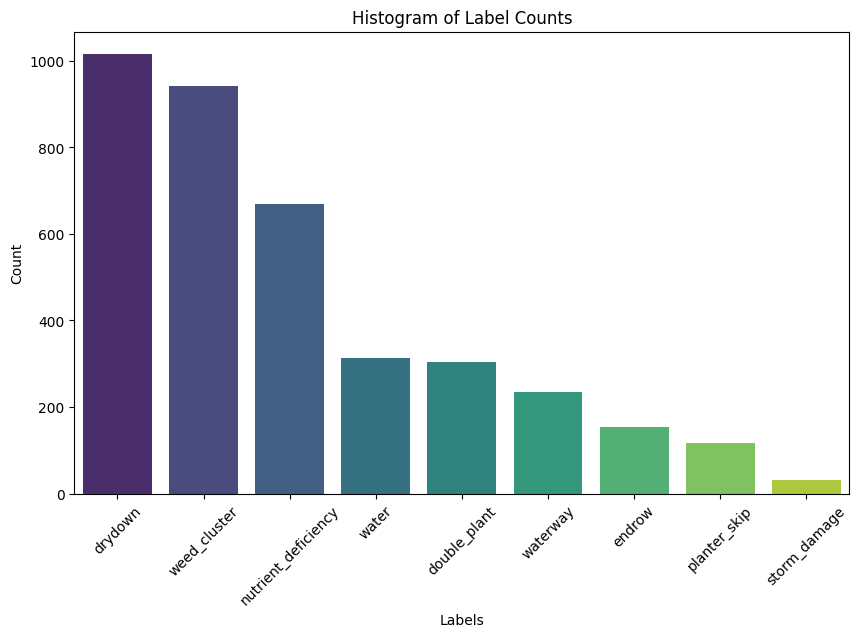

In [13]:
label_columns = df.columns[1:]  # Exclude ID
label_counts = df[label_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    hue=label_counts.index,
    dodge=False,
    palette='viridis',
    legend=False,
)
plt.title('Histogram of Label Counts')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()